In [1]:
# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = ['aws-amplify/amplify-android', 'aws-amplify/aws-sdk-android', 'awslabs/aws-mobile-appsync-sdk-android']

# Labels used across different repositories
issue_buckets = {'Bug': ['Bug'],
                 'Feature Request': ['Improvement', 'Feature Request'],
                 'Question': ['Usage Question'],
                 'Pending Triage': ['Pending Triage']}

# Date Range
start_date = '2020-04-01'
end_date = '2020-05-01'

In [2]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']

In [3]:
# Grab all issues from the GitHub V4 GraphQL API

import requests
import json

headers = {'Authorization': f'Bearer {token}'}

def get_issues(owner, name, *, end_cursor=None):
    query = """
    query($owner: String!, $name: String!, $endCursor: String) {
      repository(owner:$owner, name:$name) {
        issues(first:100, after:$endCursor) {
          nodes {
            number
            title
            createdAt
            closedAt
            reactions {
              totalCount
            }
            comments(first:100) {
              nodes {
                createdAt
                author {
                  login
                }
                reactions {
                  totalCount
                }
              }
            }
            labels(first:3) {
              nodes {
                name
              }
            }
          }
          pageInfo {
            hasNextPage
            endCursor
          }
        }
      }
    }"""
    
    variables = {'owner': owner, 'name': name, 'endCursor': end_cursor}
    response = execute(query, variables)
    page_info = response['data']['repository']['issues']['pageInfo']
    nodes = response['data']['repository']['issues']['nodes']
    
    for issue in nodes:
        yield issue
    
    if page_info['hasNextPage']:
        yield from get_issues(owner, name, end_cursor=page_info['endCursor'])
    
def execute(query, variables):
    request = requests.post('https://api.github.com/graphql', json={'query': query, 'variables': variables},
                                                              headers=headers)

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("{}: {}".format(request.status_code, query))

In [4]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    issues = []
    owner, name = repo_name.split('/')

    for issue in get_issues(owner, name):
        labels = pd.array([label['name'] for label in issue['labels']['nodes']])
        bucket = 'Other'
        created_at = pd.Timestamp(issue['createdAt'],tz='UTC')
        
        score = 1
        score += len(issue['comments']) 
        score += issue['reactions']['totalCount']
        score += sum(comment['reactions']['totalCount'] for comment in issue['comments']['nodes'])
        
        if issue['closedAt']:
            closed_at = pd.Timestamp(issue['closedAt'], tz='UTC')
        else:
            closed_at = None
            
        for label in labels:
            if label in bucket_lookup:
                bucket = label
                break
                
        issues.append([issue['number'], issue['title'], labels, created_at, closed_at, bucket, score])
        
    repos[repo_name] = pd.DataFrame(issues, columns=['id', 'title', 'labels', 'created_at', 'closed_at', 'bucket', 'score'])

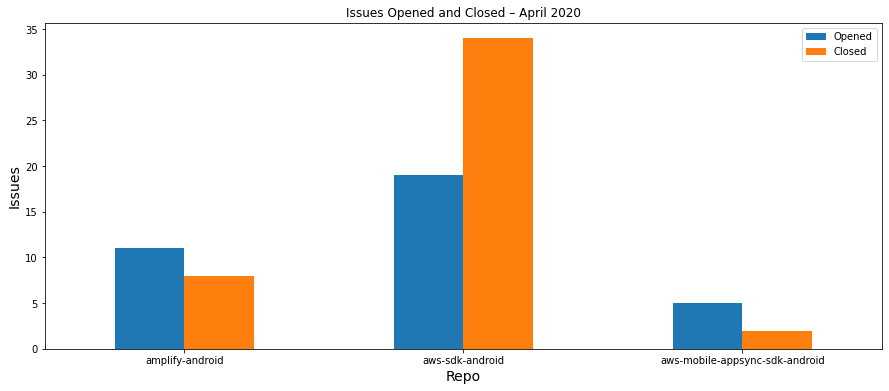

In [5]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

%matplotlib inline

opened_and_closed = []

for repo_name, df in repos.items():
    opened = df.loc[(df.created_at > start_date)] 
    opened = opened.loc[(df.created_at < end_date)] 
    closed = df.loc[(df.closed_at > start_date)]
    closed = closed.loc[(df.closed_at < end_date)]

    opened = opened.set_index('created_at')
    closed = closed.dropna().set_index('closed_at')

    repo_name = repo_name[repo_name.index('/')+1:]
    opened_and_closed.append([repo_name, opened['id'].count(), closed['id'].count()])

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})

df = pd.DataFrame(opened_and_closed, columns=['repo_name', 'Opened', 'Closed'])
ax = df.plot(kind='bar', figsize=(15, 6), legend=True)

ax.set_xlabel('Repo', fontsize=14)
ax.set_xticklabels(df['repo_name'], rotation=0)
ax.set_ylabel('Issues', fontsize=14)

ax.set(title=f'Issues Opened and Closed – April 2020')
    
plt.show()

In [6]:
# Top Closed Bugs by Activity

from IPython.display import display, HTML

display(HTML(f'<h1>Top Closed Issues by Activity</h1>'))

for repo_name, df in repos.items():
    df = df[(df.closed_at > start_date)]
    df = df[(df.closed_at < end_date)]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'bucket', 'score']].head(10))

,id,title,created_at,bucket,score
49,347,Updating SDK Core Class Not Found,2020-04-03 10:23:54+00:00,Other,4
42,293,DataStore SyncEngine to remain active even whi...,2020-03-03 20:09:48+00:00,Bug,3
44,295,Problems with datastore,2020-03-04 15:42:37+00:00,Bug,3
20,195,When we will have unity SDK ?,2019-12-12 05:21:55+00:00,Feature Request,2
53,378,IllegalStateException: Tried to get a plugin b...,2020-04-11 21:07:08+00:00,Pending Triage,2
56,384,com.amplifyframework.AmplifyException: Unknown...,2020-04-17 23:26:30+00:00,Other,2
57,405,amplify codegen models throws @Nullable @Nulla...,2020-04-27 22:32:26+00:00,Other,2
58,408,Docs RFC - Resources section,2020-04-28 23:09:57+00:00,Improvement,2


,id,title,created_at,bucket,score
539,634,RFC - Auth workflows: improvements and additions,2019-01-04 00:51:33+00:00,Feature Request,19
567,679,Refresh token expired earlier than it should o...,2019-01-29 15:32:35+00:00,Bug,8
376,429,How to include custom authorization headers wh...,2018-03-23 14:25:44+00:00,Feature Request,7
525,616,Adapt S3 TransferUtility for unstable network ...,2018-12-13 23:39:49+00:00,Feature Request,7
706,1018,Lex sample requires CognitoAuth SDK,2019-06-13 23:35:50+00:00,Bug,6
881,1482,Account for API 29 changes to storage access i...,2020-02-19 17:01:40+00:00,Other,5
862,1453,com.amazonaws.mobile.client.internal.oauth2.OA...,2020-01-24 13:38:26+00:00,Bug,5
912,1550,MqttException (0) - java.io.IOException: Alrea...,2020-04-09 08:48:16+00:00,Bug,4
909,1546,Refresh token was not automatically refreshed ...,2020-04-05 15:51:56+00:00,Usage Question,4
915,1566,federatedSignIn is unacceptably slow,2020-04-14 03:56:58+00:00,Bug,3


,id,title,created_at,bucket,score
83,133,Useless log outputs shows forever,2019-03-20 07:05:33+00:00,Feature Request,2
135,225,Deleting cascade single record,2019-11-05 11:24:31+00:00,Other,2
